In [1]:
%matplotlib tk
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
import sys
import os
import glob
sys.path.append('/home/jleland/Coding/Projects/flopter')
import magopter as mg
import constants as c
import databases.magnum as mdb
import normalisation as nrm
import lputils as lp
import classes.ivdata as ivd
import filtering as filt
import scipy.signal as sig
import fitters as fts

In [4]:
folders = ['2018-05-01_Leland/', '2018-05-02_Leland/', '2018-05-03_Leland/',
           '2018-06-05_Leland/', '2018-06-06_Leland/', '2018-06-07_Leland/']
files = []
file_folders = []
for folder1 in folders:
    os.chdir(mg.Magopter.get_data_path() + folder1)
    files.extend(glob.glob('*.adc'))
    file_folders.extend([folder1] * len(glob.glob('*.adc')))
files.sort()

# file = files[286]
file = files[285]
ts_file = files[284]
folder = file_folders[-2]
print('"{}" \t\t "{}" \t\t "{}"'.format(folder, file, ts_file))

mp = lp.MagnumProbes()
probe = mp.probe_s

"2018-06-07_Leland/" 		 "2018-06-07 14h 38m 33s TT_06564321037878221702.adc" 		 "2018-06-07 14h 33m 45s TT_06564319866763108260.adc"


In [5]:
dsr = 1

# Create magopter object
magopter = mg.Magopter(folder, file, ts_filename=ts_file)
magopter.prepare(down_sampling_rate=dsr, roi_b_plasma=True, plot_fl=False, crit_freq=None, crit_ampl=None)

print('0: {}, 1: {}'.format(len(magopter.iv_arrs[0]), len(magopter.iv_arrs[1])))

# Get values for TS measurements, depending on whether Magnum database is available.
if magopter.ts_temp is not None:
    temps = [np.max(temp) / nrm.ELEM_CHARGE for temp in magopter.ts_temp[mdb.DATA]]
    denss = [np.max(dens) for dens in magopter.ts_dens[mdb.DATA]]
    T_e_ts = np.mean(temps)
    d_T_e_ts = np.std(temps) / np.sqrt(len(temps))
    n_e_ts = np.mean(denss)
    d_n_e_ts = np.std(denss) / np.sqrt(len(denss))
else:
    T_e_ts = 1.61
    d_T_e_ts = 0.01
    n_e_ts = 1.4e20
    d_n_e_ts = 0.1e20

mp = lp.MagnumProbes()
probe_0 = mp.probe_s

Start Time:  13:38:12
End Time:  13:38:52
Beam Down Timestamp:  6564321041100203608 1528375093.15
Regular Timestamp:  6564321037878221702 1528375092.399824


/home/jleland/Coding/Environments/python3.6/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


peaks_len = 398
0: 398, 1: 398


In [6]:
print(len(magopter.iv_arrs[0]))
iv_arrs = magopter.iv_arrs[0]

# Find length of each sweep in t and print if not the expected 5000 timesteps @ 0.00002 seconds / step 
for i, iv in enumerate(iv_arrs):
    l = len(iv['t'])
    if l != 5000:
        print(i, l)

relative_t = np.zeros([len(iv_arrs), len(iv_arrs[0]['t'])])
# print(relative_t)
print(np.shape(relative_t))

for i, iv in enumerate(iv_arrs):
    relative_t[i] = iv['t'] - iv['t'][0]

398
(398, 5000)


In [7]:
plt.figure()
plt.pcolormesh(relative_t)
plt.show()

In [12]:
# Tried to do a manual time average of each data value in the IV, something weird is happening with the voltage 
# averaging. 

tav_i = np.zeros(2500)
tav_v = np.zeros_like(tav_i)

for i in range(2500):
    i_total = 0
    v_total = 0
    for j, iv in enumerate(iv_arrs):
        if j % 2 == 0:
            i_total += iv['I'][i]
            v_total += iv['V'][i]
        else:
            i_total += np.flip(iv['I'])[i]
            v_total += np.flip(iv['V'])[i]
    tav_i[i] = i_total / len(iv_arrs)
    tav_v[i] = v_total / len(iv_arrs)

In [13]:
# plt.figure()
# plt.plot(tav_v)

# plt.figure()
# plt.plot(tav_i)

**xarray Implementation**

5000


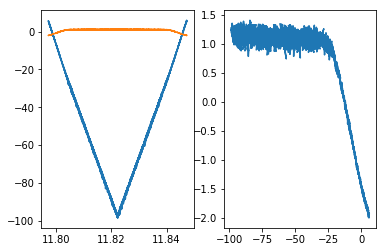

In [14]:
test_iv = iv_arrs[201]

plt.figure()
plt.subplot(121)
plt.plot(test_iv['t'], test_iv['V'])
plt.plot(test_iv['t'], test_iv['I'])

plt.subplot(122)
plt.plot(test_iv['V'], test_iv['I'])

print(len(relative_t[0]))

In [15]:
# Try with one
ds = xr.Dataset({'voltage': (['time'], test_iv['V']),
                 'current': (['time'], test_iv['I']),
                 'shot_time': (['time'], test_iv['t'])},
                coords={'time': relative_t[0]})

ds

<xarray.Dataset>
Dimensions:    (time: 5000)
Coordinates:
  * time       (time) float64 0.0 1e-05 2e-05 3e-05 ... 0.04997 0.04998 0.04999
Data variables:
    voltage    (time) float64 5.769 5.665 5.206 5.544 ... 5.752 5.847 5.388
    current    (time) float64 -1.96 -1.942 -1.916 ... -1.942 -1.951 -1.925
    shot_time  (time) float64 11.8 11.8 11.8 11.8 ... 11.85 11.85 11.85 11.85

In [8]:
# create a list of datasets for each sweep
ds_list = []
for i, iv in enumerate(iv_arrs):
    ds = xr.Dataset({'voltage': (['time'], iv['V'][:2500]),
                     'current': (['time'], iv['I'][:2500]),
                     'shot_time': (['time'], iv['t'][:2500]),
                     'start_time': iv['t'][0]},
                    coords={'time': relative_t[0][:2500]})
    ds_list.append(ds)

# add the final sweep - can't be done 
# ds_final_sweep = xr.Dataset({'voltage': (['time'], iv_arrs[-1]['V'][2500:]),
#                              'current': (['time'], iv_arrs[-1]['I'][2500:]),
#                              'shot_time': (['time'], iv_arrs[-1]['t'][2500:]),
#                              'start_time': iv_arrs[-1]['t'][2500]},
#                             coords={'time': relative_t[0][:2500]})
# print(ds_final_sweep)
# print(ds_list[0])
# ds_list.append(ds_final_sweep)
    
print(len(ds_list))
# 'direction': ('up' if i % 2 == 0 else 'down')

398


In [9]:
# Separate into up and down sweeps then concat along direction as an axis
ds_ups = xr.concat(ds_list[::2], 'sweep')
ds_downs = xr.concat(ds_list[1::2], 'sweep')

print(ds_ups)
print(ds_downs)

direction = xr.DataArray(np.array(['up', 'down']), dims=['direction'], name='direction')
direction

ds_full = xr.concat([ds_ups, ds_downs], dim=direction)
ds_full

<xarray.Dataset>
Dimensions:     (sweep: 199, time: 2500)
Coordinates:
  * time        (time) float64 0.0 1e-05 2e-05 3e-05 ... 0.02497 0.02498 0.02499
Dimensions without coordinates: sweep
Data variables:
    voltage     (sweep, time) float64 -97.54 -97.22 -98.86 ... 5.544 5.881 6.462
    current     (sweep, time) float64 1.094 1.12 1.207 ... -1.821 -1.813 -1.787
    shot_time   (sweep, time) float64 6.772 6.772 6.772 6.772 ... 16.7 16.7 16.7
    start_time  (sweep) float64 6.772 6.822 6.872 6.922 ... 16.57 16.62 16.67
<xarray.Dataset>
Dimensions:     (sweep: 199, time: 2500)
Coordinates:
  * time        (time) float64 0.0 1e-05 2e-05 3e-05 ... 0.02497 0.02498 0.02499
Dimensions without coordinates: sweep
Data variables:
    voltage     (sweep, time) float64 5.63 5.379 5.847 ... -98.13 -97.73 -97.92
    current     (sweep, time) float64 -1.908 -1.916 -1.951 ... 1.164 1.198 1.216
    shot_time   (sweep, time) float64 6.797 6.797 6.797 ... 16.72 16.72 16.72
    start_time  (sweep) float

<xarray.Dataset>
Dimensions:     (direction: 2, sweep: 199, time: 2500)
Coordinates:
  * time        (time) float64 0.0 1e-05 2e-05 3e-05 ... 0.02497 0.02498 0.02499
  * direction   (direction) <U4 'up' 'down'
Dimensions without coordinates: sweep
Data variables:
    voltage     (direction, sweep, time) float64 -97.54 -97.22 ... -97.73 -97.92
    current     (direction, sweep, time) float64 1.094 1.12 ... 1.198 1.216
    shot_time   (direction, sweep, time) float64 6.772 6.772 ... 16.72 16.72
    start_time  (direction, sweep) float64 6.772 6.822 6.872 ... 16.6 16.65 16.7

**Playing with the xarray dataset**

In [10]:
sweep_avg_up = ds_full.sel(direction = 'up').mean('sweep')
sweep_avg_dn = ds_full.sel(direction = 'down').mean('sweep')

# Add in standard deviation of each bin as a new data variable 
sweep_avg_up = sweep_avg_up.assign({'d_current': ds_full.sel(direction = 'up').std('sweep')['current']})
sweep_avg_dn = sweep_avg_up.assign({'d_current': ds_full.sel(direction = 'down').std('sweep')['current']})

print(sweep_avg_up)

<xarray.Dataset>
Dimensions:     (time: 2500)
Coordinates:
  * time        (time) float64 0.0 1e-05 2e-05 3e-05 ... 0.02497 0.02498 0.02499
    direction   <U4 'up'
Data variables:
    voltage     (time) float64 -97.61 -97.61 -97.49 -97.44 ... 5.718 5.72 5.723
    current     (time) float64 1.148 1.147 1.152 1.155 ... -1.959 -1.959 -1.959
    shot_time   (time) float64 11.72 11.72 11.72 11.72 ... 11.75 11.75 11.75
    start_time  float64 11.72
    d_current   (time) float64 0.1049 0.1019 0.09762 ... 0.05216 0.05011 0.05188


In [11]:
plt.figure()
plt.errorbar(sweep_avg_up['time'], sweep_avg_up['current'], yerr=sweep_avg_up['d_current'], 
             ecolor='silver')
# plt.plot(np.flip(sweep_avg_dn['current'].data))

plt.figure()
plt.plot(sweep_avg_up['time'].data, sweep_avg_up['current'].data - np.flip(sweep_avg_dn['current'].data))

plt.figure()
plt.plot(sweep_avg_dn['voltage'], -sweep_avg_dn['current'])

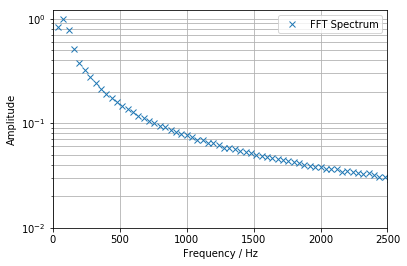

In [47]:
data = sweep_avg_up['current'].data - np.flip(sweep_avg_dn['current'].data)
time_series = sweep_avg_up['time'].data

spectrum = np.fft.fft(data)
freq = np.fft.fftfreq(len(data), time_series[1] - time_series[0])
amplitudes = np.abs(spectrum) / np.max(np.abs(spectrum))

plt.figure()
plt.semilogy(freq[1:], np.abs(spectrum[1:]) / np.max(np.abs(spectrum[1:])), 'x', label='FFT Spectrum')
# plt.axhline(y=crit_ampl, linewidth=1.0, linestyle='dotted', color='red')
plt.xlabel('Frequency / Hz')
plt.ylabel('Amplitude')
plt.grid(which='both', axis='both')
plt.xlim(0, 2500)
plt.ylim(1e-2, 1.2)
plt.legend()

2500 125
2500 125


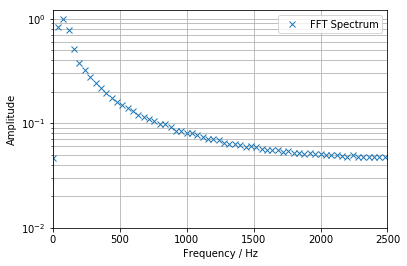

In [49]:
# Downsample in an attempt to decrease frequency range and improve resolution
data_downsampled = data[::20]
time_series_downsampled = time_series[::20]
print(len(data), len(data_downsampled))
print(len(time_series), len(time_series_downsampled))


spectrum_dwns = np.fft.fft(data_downsampled)
freq_dwns = np.fft.fftfreq(len(data_downsampled), time_series_downsampled[1] - time_series_downsampled[0])
amplitudes_dwns = np.abs(spectrum_dwns) / np.max(np.abs(spectrum_dwns))

plt.figure()
plt.semilogy(freq_dwns, amplitudes_dwns, 'x', label='FFT Spectrum')
# plt.axhline(y=crit_ampl, linewidth=1.0, linestyle='dotted', color='red')
plt.xlabel('Frequency / Hz')
plt.ylabel('Amplitude')
plt.grid(which='both', axis='both')
plt.xlim(0, 2500)
plt.ylim(1e-2, 1.2)
plt.legend()

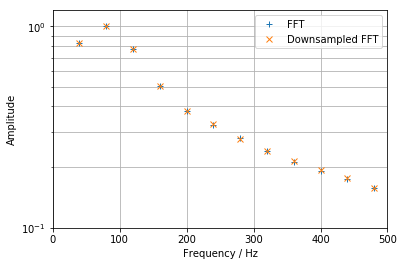

In [57]:
plt.figure()
plt.semilogy(freq, amplitudes, '+', label='FFT')
plt.semilogy(freq_dwns, amplitudes_dwns, 'x', label='Downsampled FFT')
# plt.axhline(y=crit_ampl, linewidth=1.0, linestyle='dotted', color='red')
plt.xlabel('Frequency / Hz')
plt.ylabel('Amplitude')
plt.grid(which='both', axis='both')
plt.xlim(0, 500)
plt.ylim(1e-1, 1.2)
plt.legend()

In [33]:
iv_data = ivd.IVData(sweep_avg_up['voltage'].data, sweep_avg_up['current'].data, sweep_avg_up['time'].data, 
                     sigma=sweep_avg_up['d_current'].data, estimate_error_fl=False)

iv_data.multi_fit(plot_fl=True)

simple_iv_fitter = fts.SimpleIVFitter()
iv_data.multi_fit(plot_fl=True, fitter=simple_iv_fitter)

In [44]:
class TwoTempIVFitter(fts.IVFitter):
    """
    IV Fitter implementation utilising the full, 4 parameter IV Curve fitting method with 2 temperatures
    """
    def __init__(self):
        super().__init__()
        self._param_labels = {
            c.ION_SAT: 0,
            c.SHEATH_EXP: 1,
            c.ELEC_TEMP: 2,
            c.FLOAT_POT: 3,
            'alpha':4,
            'T2': 5
        }
        self.default_values = (30.0, 0.0204, 1, -1, 0.1, 8)
        self.default_bounds = (
            (-np.inf,       0,       0, -np.inf,       0,       0),
            ( np.inf,  np.inf,  np.inf,  np.inf,  np.inf,  np.inf)
        )
        self.name = '2-Temp 4-Param Fit'

    def fit_function(self, v, *parameters):
        I_0 = parameters[self._param_labels[c.ION_SAT]]
        a = parameters[self._param_labels[c.SHEATH_EXP]]
        T_e = parameters[self._param_labels[c.ELEC_TEMP]]
        v_f = parameters[self._param_labels[c.FLOAT_POT]]
        alpha = parameters[self._param_labels['alpha']]
        T_e2 = parameters[self._param_labels['T2']]
        V1 = (v_f - v) / T_e
        V2 = (v_f - v) / T_e2
        return I_0 * (1 - np.exp(-V2) - (alpha * np.exp(-V1)) + (a * np.float_power(np.absolute(V1 + V2), [0.75])))
    
class TwoTempSimpIVFitter(fts.IVFitter):
    """
    IV Fitter implementation utilising the full, 4 parameter IV Curve fitting method with 2 temperatures
    """
    def __init__(self):
        super().__init__()
        self._param_labels = {
            c.ION_SAT: 0,
            c.ELEC_TEMP: 1,
            c.FLOAT_POT: 2,
            'alpha':3,
            'T2': 4
        }
        self.default_values = (30.0, 1, -1, 0.1, 8)
        self.default_bounds = (
            (-np.inf,       0, -np.inf,       0,       0),
            ( np.inf,  np.inf,  np.inf,  np.inf,  np.inf)
        )
        self.name = '2-Temp 3-Param Fit'

    def fit_function(self, v, *parameters):
        I_0 = parameters[self._param_labels[c.ION_SAT]]
        T_e = parameters[self._param_labels[c.ELEC_TEMP]]
        v_f = parameters[self._param_labels[c.FLOAT_POT]]
        alpha = parameters[self._param_labels['alpha']]
        T_e2 = parameters[self._param_labels['T2']]
        V1 = (v_f - v) / T_e
        V2 = (v_f - v) / 2
        return I_0 * (1 - np.exp(-V2) - (alpha * np.exp(-V1)))
    
class TwoTempImpurityIVFitter(fts.IVFitter):
    """
    IV Fitter implementation utilising the full, 4 parameter IV Curve fitting method with 2 temperatures
    """
    def __init__(self):
        super().__init__()
        self._param_labels = {
            c.ION_SAT: 0,
            c.ELEC_TEMP: 1,
            c.FLOAT_POT: 2,
            'I_sat2':3,
            'T2': 4,
            'V_f2': 5
        }
        self.default_values = (30.0, 1, -1, 15, 1.5, -1)
        self.default_bounds = (
            (    0.1,       0, -np.inf,     0.1,       0, -np.inf),
            ( np.inf,  np.inf,      10,  np.inf,  np.inf,      10)
        )
        self.name = '2-Temp 3-Param Fit'

    def fit_function(self, v, *parameters):
        I_0 = parameters[self._param_labels[c.ION_SAT]]
        T_e = parameters[self._param_labels[c.ELEC_TEMP]]
        v_f = parameters[self._param_labels[c.FLOAT_POT]]
        v_f2 = parameters[self._param_labels['V_f2']]
        I_02 = parameters[self._param_labels['I_sat2']]
        T_e2 = parameters[self._param_labels['T2']]
        V1 = (v_f - v) / T_e
        V2 = (v_f2 - v) / T_e2
        return (I_0 * (1 - np.exp(-V1))) + (I_02 * (1 - np.exp(-V2)))


In [46]:
# Implement a version of Jamie Gunn's 4-parameter fit by subtracting the straight line of the ion saturation region from the whole IV curve. 
str_sec = np.where(iv_data['V'] <= -40)
iv_data_ss = ivd.IVData.non_contiguous_trim(iv_data, str_sec)
sl_fitter = fts.StraightLineFitter()
fit_data_ss = sl_fitter.fit(iv_data_ss['V'], iv_data_ss['I'], sigma=iv_data_ss['sigma'])

fit_data_ss.plot()

# Subtract the gradient of the straight section from the whole IV curve.
iv_data_corrected = iv_data.copy()
iv_data_corrected['I'] = iv_data_corrected['I'] - (fit_data_ss.get_param('m', errors_fl=False) * iv_data_corrected['V'])

fit_data_corrected = iv_data_corrected.multi_fit(fitter=simple_iv_fitter)

plt.figure()
plt.plot(iv_data['V'], iv_data['I'], label='Full IV')
plt.plot(iv_data_ss['V'], iv_data_ss['I'], label='Straight Section')
plt.plot(iv_data_corrected['V'], iv_data_corrected['I'], label='Corrected IV')
plt.plot(*fit_data_corrected.get_fit_plottables(), label='3 Param-Fit')
plt.legend()

In [103]:
from matplotlib.widgets import Slider, Button, RadioButtons

# Implement a two temp fitter with different saturation currents (basically two IVs stacked on top of each other)
two_temp_fitter = TwoTempImpurityIVFitter()

iv_trim = ivd.IVData.percentage_trim(iv_data_corrected, trim_beg=0.05, trim_end=0.85)

# Set initial fit guess parameters
init_vals = [0.75, 1.5, -8, 0.3, 6, -21]
approx_curve = two_temp_fitter.fit_function(iv_trim['V'], *init_vals)

sl_fitter = fts.StraightLineFitter

# Create initial plot with space at the bottom for sliders
fig, ax = plt.subplots()
plt.subplots_adjust(bottom=0.3)

plt.plot(iv_data_corrected['V'], -iv_data_corrected['I'], label='Raw')
handle1, = plt.plot(iv_trim['V'], -approx_curve, label='Approx fit')
plt.legend()
plt.xlabel(r'$V_p$ / V')
plt.ylabel('I / A')
# plt.ylim([-25, 1.25])

# Create and populate sliders
axcolor = 'lightgoldenrodyellow'
axvf1 = plt.axes([0.2, 0.03, 0.55, 0.03], facecolor=axcolor)
axt1 = plt.axes([0.2, 0.06, 0.55, 0.03], facecolor=axcolor)
axisat1 = plt.axes([0.2, 0.09, 0.55, 0.03], facecolor=axcolor)

axvf2 = plt.axes([0.2, 0.14, 0.55, 0.03], facecolor=axcolor)
axt2 = plt.axes([0.2, 0.17, 0.55, 0.03], facecolor=axcolor)
axisat2 = plt.axes([0.2, 0.20, 0.55, 0.03], facecolor=axcolor)

svf1 = Slider(axvf1, r'$V_{f1}$', -30.0, 10.0, valinit=init_vals[2], valstep=0.25)
svf2 = Slider(axvf2, r'$V_{f2}$', -30.0, 10.0, valinit=init_vals[5], valstep=0.25)
st1 = Slider(axt1, r'$T_{e1}$', 0, 7.5, valinit=init_vals[1], valstep=0.05)
st2 = Slider(axt2, r'$T_{e2}$', 0, 7.5, valinit=init_vals[4], valstep=0.05)
si1 = Slider(axisat1, r'$I_{sat,1}$', 0, 1.1, valinit=init_vals[0], valstep=0.05)
si2 = Slider(axisat2, r'$I_{sat,2}$', 0, 1.1, valinit=init_vals[3], valstep=0.05)

def update(val):
    v_f1 = svf1.val
    v_f2 = svf2.val
    t_1 = st1.val
    t_2 = st2.val
    isat_1 = si1.val
    isat_2 = si2.val
    
    new_init_vals = [isat_1, t_1, v_f1, isat_2, t_2, v_f2]
    handle1.set_ydata(-two_temp_fitter.fit_function(iv_trim['V'], *new_init_vals))
    fig.canvas.draw_idle()
    
svf1.on_changed(update)
svf2.on_changed(update)
st1.on_changed(update)
st2.on_changed(update)
si1.on_changed(update)
si2.on_changed(update)

fitax = plt.axes([0.8, 0.025, 0.1, 0.04])
button = Button(fitax, 'Fit', color=axcolor, hovercolor='0.975')

def plot_fit(event):
    v_f1 = svf1.val
    v_f2 = svf2.val
    t_1 = st1.val
    t_2 = st2.val
    isat_1 = si1.val
    isat_2 = si2.val
    
    new_init_vals = [isat_1, t_1, v_f1, isat_2, t_2, v_f2]
    fit_data_tti = two_temp_fitter.fit_iv_data(iv_trim, initial_vals=new_init_vals)
    handle1.set_ydata(-fit_data_tti.fit_y)
    
    fit_vals = fit_data_tti.fit_params.get_values()
    si1.set_val(fit_vals[0])
    st1.set_val(fit_vals[1])
    svf1.set_val(fit_vals[2])
    si2.set_val(fit_vals[3])
    st2.set_val(fit_vals[4])
    svf2.set_val(fit_vals[5])
    update(event)
    
button.on_clicked(plot_fit)



plt.show()

# fit_data_tti = two_temp_fitter.fit_iv_data(iv_trim)
# fit_data_tti.plot()

# print(two_temp_fitter.has_fixed_values())
# iv_data.multi_fit(plot_fl=True, fitter=two_temp_fitter, print_fl=True)

**Playing with Trimming to get a Different/Better Fit**

In [86]:
steps = 30

top_trims = np.flip(np.linspace(0.67, 1.0, steps))
bot_trims = np.linspace(0.0, 0.5, steps)
top_fits = []
bot_fits = []
combi_fits = []
fitted_ttrims = []
fitted_btrims = []
fitted_ctrims = []

for i in range(steps):
    # Create trimmed IVData object and run the multi-fitting algorithm for both top and bottom trims
    top_trim = top_trims[i]
    bot_trim = bot_trims[i]
    try:
        iv_data_ttrim = ivd.IVData.percentage_trim(iv_data, trim_beg=0.4, trim_end=top_trim)
        top_fits.append(iv_data_ttrim.multi_fit()) #.get_temp(errors_fl=False)
        fitted_ttrims.append(top_trim)
    except:
        print('Skipping fit at top trim = {}'.format(top_trim))
        
    try:
        iv_data_btrim = ivd.IVData.percentage_trim(iv_data, trim_beg=bot_trim, trim_end=0.85)
        bot_fits.append(iv_data_btrim.multi_fit()) 
        fitted_btrims.append(bot_trim)
    except:
        print('Skipping fit at bot trim = {}'.format(top_trim))
    
    try:
        iv_data_ctrim = ivd.IVData.percentage_trim(iv_data, trim_beg=bot_trim, trim_end=top_trim)
        combi_fits.append(iv_data_ctrim.multi_fit()) 
        fitted_ctrims.append([bot_trim, top_trim])
    except:
        print('Skipping fit at combi trim = {}'.format([bot_trim, top_trim]))
    

# Compile the fitdatas into pandas dataframes to allow easier plotting
top_fit_df = pd.DataFrame([fit_data.to_dict() for fit_data in top_fits], index=fitted_ttrims)
bot_fit_df = pd.DataFrame([fit_data.to_dict() for fit_data in bot_fits], index=fitted_btrims)
combi_fit_df = pd.DataFrame([fit_data.to_dict() for fit_data in combi_fits], index=np.array(fitted_ctrims)[:, 1])

# print(top_fit_df)

Skipping fit at bot trim = 0.6927586206896552
Skipping fit at combi trim = [0.46551724137931033, 0.6927586206896552]


In [87]:
print(len(fitted_ctrims))

cm = plt.get_cmap('gist_rainbow')
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(iv_data['V'], iv_data['I'], label='Full Binned IV', color='black')

ax.set_prop_cycle(color=[cm(i / len(fitted_ctrims)) for i in range(len(fitted_ctrims))])
for i, lims in enumerate(fitted_ctrims):
    pos = (np.array(lims) * len(iv_data['V'])).astype(np.int) - 1
    ax.vlines(iv_data['V'][pos], iv_data['I'][pos]-0.1, iv_data['I'][pos]+.1, label='Step {}'.format(i))
    
ax.axvline(x=iv_data['V'][int(0.82 * len(iv_data['V'])) - 1])
ax.axhline(y=0)

29


In [88]:
# plot T_e and I_sat:
for fit_df in [top_fit_df, bot_fit_df, combi_fit_df]:
    fig, ax = plt.subplots(2, 1, sharex=True, sharey=False)

    plt.sca(ax[0])
    plt.errorbar(fit_df.index, fit_df['T_e'], yerr=fit_df['d_T_e'], label='Temperature', ecolor='silver') 
    ax[0].set_ylabel(r'$T_e$ / eV')

    ax0_twin = ax[0].twinx()
    plt.plot(fit_df.index, fit_df['reduced_chi2'], label=r'$\chi^2$', color='gray')
    plt.legend()


    plt.sca(ax[1])
    plt.errorbar(fit_df.index, fit_df['I_sat'], yerr=fit_df['d_I_sat'], label=r'$I_{sat}$', color='red', ecolor='silver') 
    ax[0].set_ylabel(r'$I_{sat}$ / eV')

    ax0_twin = ax[1].twinx()
    plt.plot(fit_df.index, fit_df['reduced_chi2'], label=r'$\chi^2$', color='gray')
    plt.legend()


    plt.figure()
    plt.plot(fit_df.index, fit_df['reduced_chi2'], label=r'$\chi^2$', color='gray')
    plt.axhline(y=1, color='black', linewidth=1, linestyle='--')

In [14]:
plt.figure()
plt.plot(iv_data['V'], iv_data['I'], label='Full Binned IV')

fits = {}

for trim in np.linspace(0.0, 0.6, 100):
    iv_data_trim = ivd.IVData.percentage_trim(iv_data, trim_beg=trim, trim_end=0.85)
#     plt.plot(iv_data_trim['V'], iv_data_trim['I'], label='Trim = {:.2g}'.format(trim))
    try:
        fdata = iv_data_trim.multi_fit()
        fits[trim] = fdata.get_temp(errors_fl=False)
        plt.plot(fdata.raw_x, fdata.fit_y, label='Trim = {:.2g}'.format(trim))
    except:
        continue
    
plt.legend()

# for fit in fits:
plt.figure()
plt.plot(list(fits.keys()), list(fits.values())) 

<xarray.Dataset>
Dimensions:     (time: 2500)
Coordinates:
  * time        (time) float64 0.0 1e-05 2e-05 3e-05 ... 0.02497 0.02498 0.02499
    direction   <U4 'up'
Data variables:
    voltage     (time) float64 -97.61 -97.61 -97.49 -97.44 ... 5.718 5.72 5.723
    current     (time) float64 1.148 1.147 1.152 1.155 ... -1.959 -1.959 -1.959
    shot_time   (time) float64 11.72 11.72 11.72 11.72 ... 11.75 11.75 11.75
    start_time  float64 11.72


<IPython.core.display.Javascript object>


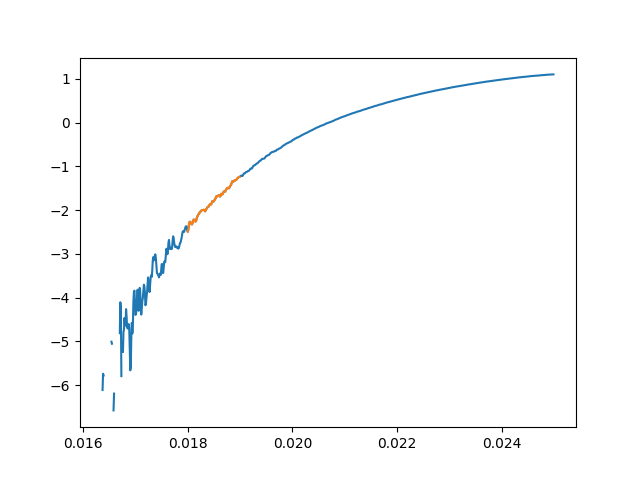

/home/jleland/Coding/Environments/python3.6/lib/python3.6/site-packages/xarray/core/computation.py:561: RuntimeWarning: invalid value encountered in log
  result_data = func(*input_data)


<IPython.core.display.Javascript object>


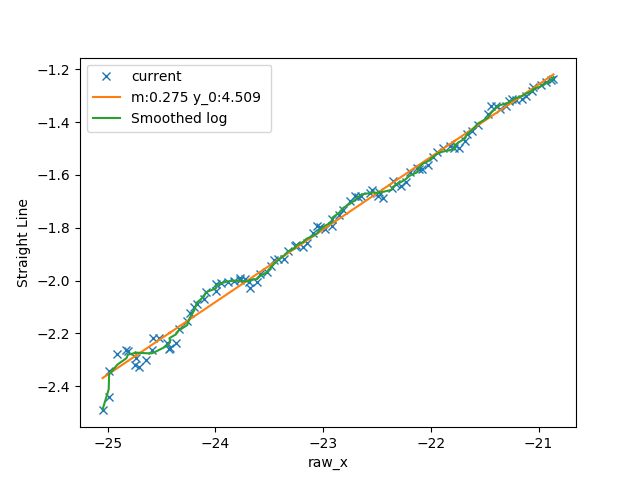

/home/jleland/Coding/Environments/python3.6/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


<IPython.core.display.Javascript object>


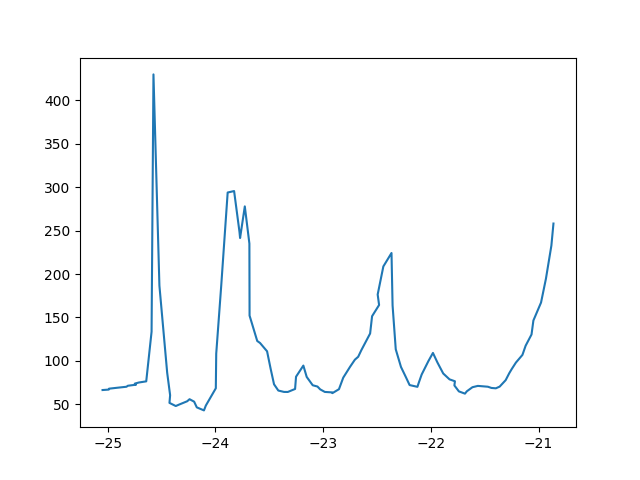

In [174]:
# fitting to a log plot  

print(sweep_avg_up)

plt.figure()
plt.plot(sweep_avg_up['time'], np.log(-sweep_avg_up['current'] + 1.06))

trim_sweep_avg_up = sweep_avg_up.where((sweep_avg_up.time <= 0.019) & (sweep_avg_up.time > 0.018), drop=True)
plt.plot(trim_sweep_avg_up['time'], np.log(-trim_sweep_avg_up['current'] + 1.06))

sl_fitter = fts.StraightLineFitter()
fit_data_log = sl_fitter.fit(trim_sweep_avg_up['voltage'].data, np.log(-trim_sweep_avg_up['current'] + 1.06))

fig = plt.figure()
fit_data_log.plot(fig=fig, show_fl=False)
plt.plot(trim_sweep_avg_up['voltage'].data, sig.savgol_filter(np.log(-trim_sweep_avg_up['current'] + 1.06), 21, 4),
         label='Smoothed log')
plt.legend()

# Attempt to find temperature by using the gradient function in numpy
temperature = 1/np.gradient(sig.savgol_filter(np.log(-trim_sweep_avg_up['current'] + 1.06), 21, 2))
plt.figure()
plt.plot(trim_sweep_avg_up['voltage'].data, temperature)

/home/jleland/Coding/Environments/python3.6/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


<IPython.core.display.Javascript object>


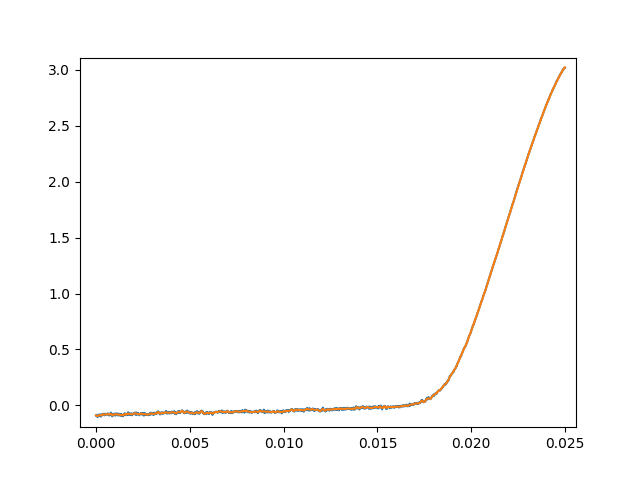

In [175]:
i_sat_approximation = 1.06

prelog_data =  -sweep_avg_up['current'] + i_sat_approximation
prelog_smoothed = sig.savgol_filter(prelog_data, 21, 2)

plt.figure()
plt.plot(sweep_avg_up['time'], prelog_data)
plt.plot(sweep_avg_up['time'], prelog_smoothed)

**Bug found with xarray plotting software**

<xarray.DataArray 'current' (time: 2500)>
array([-0.405366, -0.405997, -0.400823, ..., -0.409823, -0.405345, -0.402388])
Coordinates:
  * time     (time) float64 0.0 1e-05 2e-05 3e-05 ... 0.02497 0.02498 0.02499
    voltage  (time) float64 -45.96 -45.99 -45.96 -45.96 ... -45.99 -46.04 -46.0


<IPython.core.display.Javascript object>


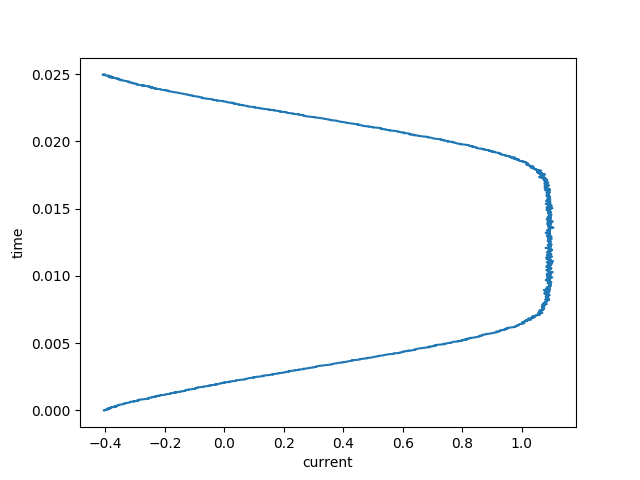

In [93]:
# Buggy bit of xarray when trying to plot I against V

buggy_data = sweep_avg.set_coords('voltage')['current']
print(buggy_data)

plt.figure()
buggy_data.plot.line(x='voltage')